In [1]:
!pip install pandera --upgrade

In [2]:
!pip install ipykernel==5.5.6 notebook==6.5.5

In [3]:
# top k items to recommend
TOP_K = 10

# Model parameters
EPOCHS = 50
BATCH_SIZE = 256

SEED = 42

## Prepare Dataset

In [15]:
import pandas as pd

df_D = pd.read_csv("tn_visit_area_info_travel_D.csv")
df_E = pd.read_csv("tn_visit_area_info_travel.csv")

merged_df = pd.concat([df_D, df_E], axis=0, ignore_index=True)
print(merged_df.shape)
merged_df.head()

(22552, 23)


,VISIT_AREA_ID,TRAVEL_ID,VISIT_ORDER,VISIT_AREA_NM,VISIT_START_YMD,VISIT_END_YMD,ROAD_NM_ADDR,LOTNO_ADDR,X_COORD,Y_COORD,...,POI_NM,RESIDENCE_TIME_MIN,VISIT_AREA_TYPE_CD,REVISIT_YN,VISIT_CHC_REASON_CD,LODGING_TYPE_CD,DGSTFN,REVISIT_INTENTION,RCMDTN_INTENTION,SGG_CD
0,2210300003,a_a008632,7,송도센트럴파크,2022-10-30,2022-10-30,NaN,인천 연수구 송도동 24-5,126.638630,37.39306396,...,스트롤링가든브릿지,120.0,1,N,1.0,NaN,4.0,5.0,4.0,NaN
1,2210220007,d_d004269,11,원앙폭포,2022-10-22,2022-10-22,제주특별자치도 서귀포시 돈내코로 137,제주특별자치도 서귀포시 상효동 1463,126.581330,33.30017689,...,NaN,30.0,1,N,9.0,NaN,3.0,2.0,3.0,NaN
2,2209070004,c_c000751,11,쏠비치진도 인피니티풀,2022-09-07,2022-09-07,전남 진도군 의신면 송군길 30-40,전남 진도군 의신면 초사리 1204,126.327957,34.40073398,...,NaN,480.0,6,N,5.0,NaN,5.0,5.0,5.0,NaN
3,2208200006,d_d000233,18,소노캄제주 수영장,2022-08-20,2022-08-20,일주동로6347-17,제주특별자치도 서귀포시 표선면,126.792098,33.3055558,...,NaN,120.0,6,N,7.0,NaN,4.0,4.0,4.0,50130.0
4,2208260005,d_d000480,18,정방폭포,2022-08-26,2022-08-26,NaN,제주특별자치도 서귀포시 동홍동 299-3,126.571605,33.24499661,...,정방폭포,30.0,1,Y,2.0,NaN,5.0,5.0,5.0,NaN


In [16]:
item_type_df = merged_df[['VISIT_AREA_ID', 'VISIT_AREA_TYPE_CD']]
item_type_df = item_type_df[item_type_df['VISIT_AREA_TYPE_CD'].notna()]
item_type_df.shape

(22552, 2)

In [17]:
import pandas as pd

df_D = pd.read_csv("tn_visit_area_info_travel_D.csv")

# df.columns
df_D = df_D[['TRAVEL_ID', 'VISIT_AREA_ID', 'REVISIT_INTENTION', 'VISIT_START_YMD', 'VISIT_AREA_TYPE_CD']]
df_D = df_D.dropna()
df_D.rename(columns={
    'TRAVEL_ID': 'userID',
    'VISIT_AREA_ID': 'itemID',
    'REVISIT_INTENTION': 'rating',
    'VISIT_START_YMD': 'timestamp',
    'VISIT_AREA_TYPE_CD': 'itemType'
}, inplace=True)
df_D.shape

(11266, 5)

In [18]:
import pandas as pd

df_E = pd.read_csv("tn_visit_area_info_travel.csv")

# df.columns
df_E = df_E[['TRAVEL_ID', 'VISIT_AREA_ID', 'REVISIT_INTENTION', 'VISIT_START_YMD', 'VISIT_AREA_TYPE_CD']]
df_E = df_E.dropna()
df_E.rename(columns={
    'TRAVEL_ID': 'userID',
    'VISIT_AREA_ID': 'itemID',
    'REVISIT_INTENTION': 'rating',
    'VISIT_START_YMD': 'timestamp',
    'VISIT_AREA_TYPE_CD': 'itemType'
}, inplace=True)
# columns = ['userID', 'itemID', 'rating', 'timestamp']
# df.columns = columns
df_E.shape

(11266, 5)

In [19]:
df = pd.concat([df_D, df_E], axis=0, ignore_index=True)
df.to_csv("tn_visit_area_info_total.csv", index=False)
df.shape

(22532, 5)

In [20]:
df = df[df['itemType'].notna()]
df.shape

(22532, 5)

In [21]:
df['userID'] = pd.factorize(df['userID'])[0]
df['rating'] = df['rating'].replace('', 0).astype(float)

In [22]:
df.shape

(22532, 5)

In [23]:
item_type_df = df[['itemID', 'itemType']]
df = df.drop('itemType', axis=1)
print(item_type_df.shape)
print(df.shape)

(22532, 2)
(22532, 4)


In [25]:
# Make a list of (user, item, rating) tuples
dataset = []
cornac_df = df[['userID', 'itemID', 'rating']]

for index, row in cornac_df.iterrows():
    dataset.append((row['userID'], row['itemID'], row['rating']))

dataset[:10]

[(0.0, 2210300003.0, 5.0),
 (1.0, 2210220007.0, 2.0),
 (2.0, 2209070004.0, 5.0),
 (3.0, 2208200006.0, 4.0),
 (4.0, 2208260005.0, 5.0),
 (5.0, 2211060002.0, 5.0),
 (6.0, 2210040001.0, 4.0),
 (7.0, 2210270003.0, 5.0),
 (8.0, 2210270002.0, 3.0),
 (9.0, 2211130002.0, 3.0)]

In [26]:
item_type_df.head()

,itemID,itemType
0,2210300003,1
1,2210220007,1
2,2209070004,6
3,2208200006,6
4,2208260005,1


In [107]:
# ITEM Feature Modality 생성 작업
# 현재 선정한 featuer: 장소 카테고리 타입

# One-Hot Encoding 수행
item_features = pd.get_dummies(item_type_df['itemType'], prefix='type')

# itemID와 One-Hot Encoding된 특징 연결
item_features = pd.concat([item_type_df['itemID'], item_features], axis=1)

# 아이템별 feature 데이터를 딕셔너리 형태로 변환
item_feature_dict = item_features.set_index('itemID').T.to_dict('list')

<ipython-input-107-85eb43b7e556>:11: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  item_feature_dict = item_features.set_index('itemID').T.to_dict('list')


In [28]:
print(item_feature_dict)

{2210300003: [True, False, False, False, False, False, False, False], 2210220007: [False, True, False, False, False, False, False, False], 2209070004: [False, False, True, False, False, False, False, False], 2208200006: [True, False, False, False, False, False, False, False], 2208260005: [False, False, False, True, False, False, False, False], 2211060002: [True, False, False, False, False, False, False, False], 2210040001: [False, False, False, True, False, False, False, False], 2210270003: [True, False, False, False, False, False, False, False], 2210270002: [True, False, False, False, False, False, False, False], 2211130002: [True, False, False, False, False, False, False, False], 2210250003: [False, True, False, False, False, False, False, False], 2210160004: [False, True, False, False, False, False, False, False], 2210230002: [True, False, False, False, False, False, False, False], 2210290003: [False, False, False, True, False, False, False, False], 2210220001: [True, False, False, 

## Model Evaluation

In [29]:
import cornac
from cornac.eval_methods import RatioSplit
from cornac.models import MF
from cornac.metrics import RMSE, MAE, Precision, Recall
from cornac.data import FeatureModality

# 평가 방법 설정: 훈련 80%, 테스트 20%
ratio_split = RatioSplit(data=dataset, test_size=0.2, rating_threshold=4.0, verbose=True)

# Matrix Factorization (MF) 모델 생성
mf_model = MF(k=10, max_iter=50, learning_rate=0.01, lambda_reg=0.02, verbose=True)

# 성능 평가를 위한 실험 설정
exp = cornac.Experiment(eval_method=ratio_split, models=[mf_model], metrics=[RMSE(), MAE(), Precision(k=10), Recall(k=10)])

# 모델 학습 및 평가
exp.run()

rating_threshold = 4.0
exclude_unknowns = True
---
Training data:
Number of users = 3489
Number of items = 1062
Number of ratings = 10812
Max rating = 5.0
Min rating = 1.0
Global mean = 4.1
---
Test data:
Number of users = 3489
Number of items = 1062
Number of ratings = 4009
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 3489
Total items = 1062

[MF] Training started!


/usr/local/lib/python3.10/dist-packages/cornac/data/dataset.py:339: UserWarning: 7213 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/usr/local/lib/python3.10/dist-packages/cornac/data/dataset.py:339: UserWarning: 410 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!

[MF] Evaluation started!


Rating:   0%|          | 0/4009 [00:00<?, ?it/s]

Ranking:   0%|          | 0/2326 [00:00<?, ?it/s]


TEST:
...
   |    MAE |   RMSE | Precision@10 | Recall@10 | Train (s) | Test (s)
-- + ------ + ------ + ------------ + --------- + --------- + --------
MF | 0.5600 | 0.5895 |       0.0007 |    0.0049 |    0.2070 |   2.0054



In [106]:
import cornac

# Item Feature Modality 설정
# 현재 선정한 featuer: 장소 카테고리 타입
item_feature_modality = cornac.data.FeatureModality(data=item_feature_dict)

# Split data based on ratio
rs = cornac.eval_methods.RatioSplit(
    data=dataset, test_size=0.2, rating_threshold=4.0, seed=123, item_feature=item_feature_modality, verbose=True
)

# Here we are comparing biased MF, PMF, and BPR
mf = cornac.models.MF(
    k=10, max_iter=25, learning_rate=0.01, lambda_reg=0.02, use_bias=True, seed=123
)
pmf = cornac.models.PMF(
    k=10, max_iter=100, learning_rate=0.001, lambda_reg=0.001, seed=123
)
bpr = cornac.models.BPR(
    k=10, max_iter=200, learning_rate=0.001, lambda_reg=0.01, seed=123
)

most_pop = cornac.models.MostPop()

item_knn_bm25 = cornac.models.ItemKNN(
        k=100, similarity="cosine", weighting="bm25", name="ItemKNN-BM25"
    )
bpr = cornac.models.BPR(k=10, max_iter=200, learning_rate=0.001, lambda_reg=0.01, seed=123)
wmf = cornac.models.WMF(
    k=5,
    max_iter=50,
    learning_rate=0.001,
    lambda_u=0.01,
    lambda_v=0.01,
    verbose=True,
    seed=123,
)
vaecf = cornac.models.VAECF(
    k=5,
    autoencoder_structure=[20],
    act_fn="tanh",
    likelihood="mult",
    n_epochs=100,
    batch_size=100,
    learning_rate=0.001,
    beta=1.0,
    seed=123,
    use_gpu=True,
    verbose=True,
)

# Define metrics used to evaluate the models
mae = cornac.metrics.MAE()
rmse = cornac.metrics.RMSE()
prec = cornac.metrics.Precision(k=10)
recall = cornac.metrics.Recall(k=10)
ndcg = cornac.metrics.NDCG(k=10)
auc = cornac.metrics.AUC()
mAP = cornac.metrics.MAP()

# Put it together into an experiment and run
cornac.Experiment(
    eval_method=rs,
    models=[mf, pmf, bpr, vaecf, item_knn_bm25],
    metrics=[mae, rmse, prec, recall, ndcg, auc, mAP],
    user_based=True,
    save_dir="save_models"
).run()

rating_threshold = 4.0
exclude_unknowns = True
---
Training data:
Number of users = 3501
Number of items = 1064
Number of ratings = 10835
Max rating = 5.0
Min rating = 1.0
Global mean = 4.1
---
Test data:
Number of users = 3501
Number of items = 1064
Number of ratings = 4044
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 3501
Total items = 1064


/usr/local/lib/python3.10/dist-packages/cornac/data/dataset.py:339: UserWarning: 7190 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/usr/local/lib/python3.10/dist-packages/cornac/data/dataset.py:339: UserWarning: 399 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)



[MF] Training started!

[MF] Evaluation started!


Rating:   0%|          | 0/4044 [00:00<?, ?it/s]

Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[PMF] Training started!

[PMF] Evaluation started!


Rating:   0%|          | 0/4044 [00:00<?, ?it/s]

Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[BPR] Training started!

[BPR] Evaluation started!


Rating:   0%|          | 0/4044 [00:00<?, ?it/s]

Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[VAECF] Training started!


  0%|          | 0/100 [00:00<?, ?it/s]


[VAECF] Evaluation started!


Rating:   0%|          | 0/4044 [00:00<?, ?it/s]

Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]

VAECF model is saved to save_models/VAECF/2024-09-11_08-34-40-435345.pkl

[ItemKNN-BM25] Training started!


  0%|          | 0/1064 [00:00<?, ?it/s]


[ItemKNN-BM25] Evaluation started!


Rating:   0%|          | 0/4044 [00:00<?, ?it/s]

Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]

ItemKNN-BM25 model is saved to save_models/ItemKNN-BM25/2024-09-11_08-34-48-257494.pkl

TEST:
...
             |    MAE |   RMSE |    AUC |    MAP | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
------------ + ------ + ------ + ------ + ------ + ------- + ------------ + --------- + --------- + --------
MF           | 0.6175 | 0.6458 | 0.5487 | 0.0073 |  0.0034 |       0.0011 |    0.0069 |    0.0151 |  10.8704
PMF          | 0.5588 | 0.5918 | 0.9504 | 0.3309 |  0.3756 |       0.0723 |    0.5172 |    0.3898 |   5.9350
BPR          | 2.9805 | 3.0205 | 0.7814 | 0.0375 |  0.0382 |       0.0100 |    0.0732 |    0.3716 |   3.6450
VAECF        | 3.0624 | 3.1014 | 0.9682 | 0.1808 |  0.2278 |       0.0608 |    0.4223 |   16.2397 |   8.2979
ItemKNN-BM25 | 0.4683 | 0.4958 | 0.7262 | 0.0390 |  0.0631 |       0.0171 |    0.1310 |    0.1002 |   7.6868



## Hyperparameter Tuning in PMF using RandomSearchCV

In [31]:
import numpy as np
import cornac
from cornac.eval_methods import RatioSplit
from cornac.metrics import Recall, NDCG, Precision

# 하이퍼파라미터 범위 설정
param_grid = {
    'k': np.random.choice([5, 10, 20, 50]),  # latent factors 수
    'learning_rate': np.random.uniform(0.0001, 0.01, 5),  # 학습률
    'lambda_reg': np.random.uniform(0.0001, 0.01, 5)  # regularization strength
}

best_score = -np.inf
best_params = {}

# Split data based on ratio
rs = cornac.eval_methods.RatioSplit(
    data=dataset, test_size=0.2, rating_threshold=4.0, seed=123, item_feature=item_feature_modality, verbose=True
)

# Random SearchCV 루프
for i in range(10):  # 10번의 랜덤 탐색
    params = {key: np.random.choice(values) for key, values in param_grid.items()}

    # PMF 모델 생성
    print(params)
    pmf = cornac.models.PMF(k=params['k'], max_iter=100, learning_rate=params['learning_rate'], lambda_reg=params['lambda_reg'])
    bpr = cornac.models.BPR(k=params['k'], max_iter=100, learning_rate=params['learning_rate'], lambda_reg=params['lambda_reg'])
    item_knn_bm25 = cornac.models.ItemKNN(
        k=params['k'], similarity="cosine", weighting="bm25", name="ItemKNN-BM25"
    )

    # 실험 실행
    experiment = cornac.Experiment(eval_method=rs, models=[pmf, bpr, item_knn_bm25], metrics=[Precision(k=10), Recall(k=10), NDCG(k=10)]).run()

# print(f"Best Recall: {best_score}, Best Params: {best_params}")

rating_threshold = 4.0
exclude_unknowns = True
---
Training data:
Number of users = 3501
Number of items = 1064
Number of ratings = 10835
Max rating = 5.0
Min rating = 1.0
Global mean = 4.1
---
Test data:
Number of users = 3501
Number of items = 1064
Number of ratings = 4044
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 3501
Total items = 1064
{'k': 24, 'learning_rate': 0.006556789196632666, 'lambda_reg': 0.005768680727585771}

[PMF] Training started!


/usr/local/lib/python3.10/dist-packages/cornac/data/dataset.py:339: UserWarning: 7190 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/usr/local/lib/python3.10/dist-packages/cornac/data/dataset.py:339: UserWarning: 399 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)



[PMF] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[BPR] Training started!

[BPR] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[ItemKNN-BM25] Training started!


  0%|          | 0/1064 [00:00<?, ?it/s]


[ItemKNN-BM25] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


TEST:
...
             | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
------------ + ------- + ------------ + --------- + --------- + --------
PMF          |  0.6619 |       0.1120 |    0.7702 |    1.0907 |   3.7039
BPR          |  0.0384 |       0.0101 |    0.0737 |    0.2476 |   1.6297
ItemKNN-BM25 |  0.0631 |       0.0171 |    0.1310 |    0.1254 |   3.8089

{'k': 46, 'learning_rate': 0.009618079434656595, 'lambda_reg': 0.001090495822583596}

[PMF] Training started!

[PMF] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[BPR] Training started!

[BPR] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[ItemKNN-BM25] Training started!


  0%|          | 0/1064 [00:00<?, ?it/s]


[ItemKNN-BM25] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


TEST:
...
             | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
------------ + ------- + ------------ + --------- + --------- + --------
PMF          |  0.7209 |       0.1134 |    0.7734 |    1.6530 |   1.6922
BPR          |  0.0389 |       0.0106 |    0.0781 |    0.2184 |   3.8302
ItemKNN-BM25 |  0.0631 |       0.0171 |    0.1310 |    0.1073 |   3.8991

{'k': 44, 'learning_rate': 0.009618079434656595, 'lambda_reg': 0.008201971647789514}

[PMF] Training started!

[PMF] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[BPR] Training started!

[BPR] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[ItemKNN-BM25] Training started!


  0%|          | 0/1064 [00:00<?, ?it/s]


[ItemKNN-BM25] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


TEST:
...
             | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
------------ + ------- + ------------ + --------- + --------- + --------
PMF          |  0.6546 |       0.1151 |    0.7935 |    1.5574 |   1.8420
BPR          |  0.0401 |       0.0099 |    0.0734 |    0.1993 |   1.4711
ItemKNN-BM25 |  0.0631 |       0.0171 |    0.1310 |    0.1154 |   5.9945

{'k': 25, 'learning_rate': 0.0017664089523507123, 'lambda_reg': 0.008201971647789514}

[PMF] Training started!

[PMF] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[BPR] Training started!

[BPR] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[ItemKNN-BM25] Training started!


  0%|          | 0/1064 [00:00<?, ?it/s]


[ItemKNN-BM25] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


TEST:
...
             | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
------------ + ------- + ------------ + --------- + --------- + --------
PMF          |  0.7103 |       0.1220 |    0.8300 |    0.9268 |   1.7927
BPR          |  0.0405 |       0.0102 |    0.0745 |    0.1934 |   1.5900
ItemKNN-BM25 |  0.0631 |       0.0171 |    0.1310 |    0.1155 |   7.2121

{'k': 37, 'learning_rate': 0.006556789196632666, 'lambda_reg': 0.005731724281492569}

[PMF] Training started!

[PMF] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[BPR] Training started!

[BPR] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[ItemKNN-BM25] Training started!


  0%|          | 0/1064 [00:00<?, ?it/s]


[ItemKNN-BM25] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


TEST:
...
             | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
------------ + ------- + ------------ + --------- + --------- + --------
PMF          |  0.6922 |       0.1175 |    0.8048 |    1.3435 |   1.8457
BPR          |  0.0390 |       0.0102 |    0.0760 |    0.2673 |   1.5821
ItemKNN-BM25 |  0.0631 |       0.0171 |    0.1310 |    0.1108 |   6.1794

{'k': 23, 'learning_rate': 0.006556789196632666, 'lambda_reg': 0.0029045739160953802}

[PMF] Training started!

[PMF] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[BPR] Training started!

[BPR] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[ItemKNN-BM25] Training started!


  0%|          | 0/1064 [00:00<?, ?it/s]


[ItemKNN-BM25] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


TEST:
...
             | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
------------ + ------- + ------------ + --------- + --------- + --------
PMF          |  0.6678 |       0.1084 |    0.7422 |    0.8230 |   1.7718
BPR          |  0.0404 |       0.0099 |    0.0725 |    0.2689 |   1.5599
ItemKNN-BM25 |  0.0631 |       0.0171 |    0.1310 |    0.1085 |   3.8819

{'k': 20, 'learning_rate': 0.005092284661675131, 'lambda_reg': 0.0029045739160953802}

[PMF] Training started!

[PMF] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[BPR] Training started!

[BPR] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[ItemKNN-BM25] Training started!


  0%|          | 0/1064 [00:00<?, ?it/s]


[ItemKNN-BM25] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


TEST:
...
             | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
------------ + ------- + ------------ + --------- + --------- + --------
PMF          |  0.6553 |       0.1068 |    0.7345 |    0.7613 |   3.2170
BPR          |  0.0380 |       0.0101 |    0.0736 |    0.3864 |   1.9626
ItemKNN-BM25 |  0.0631 |       0.0171 |    0.1310 |    0.1453 |   3.8826

{'k': 42, 'learning_rate': 0.005092284661675131, 'lambda_reg': 0.008201971647789514}

[PMF] Training started!

[PMF] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[BPR] Training started!

[BPR] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[ItemKNN-BM25] Training started!


  0%|          | 0/1064 [00:00<?, ?it/s]


[ItemKNN-BM25] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


TEST:
...
             | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
------------ + ------- + ------------ + --------- + --------- + --------
PMF          |  0.6899 |       0.1201 |    0.8217 |    1.5152 |   1.7824
BPR          |  0.0394 |       0.0097 |    0.0711 |    0.2930 |   2.0731
ItemKNN-BM25 |  0.0631 |       0.0171 |    0.1310 |    0.1883 |   5.2471

{'k': 22, 'learning_rate': 0.0008566751923222126, 'lambda_reg': 0.005768680727585771}

[PMF] Training started!

[PMF] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[BPR] Training started!

[BPR] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[ItemKNN-BM25] Training started!


  0%|          | 0/1064 [00:00<?, ?it/s]


[ItemKNN-BM25] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


TEST:
...
             | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
------------ + ------- + ------------ + --------- + --------- + --------
PMF          |  0.6403 |       0.1133 |    0.7791 |    0.8463 |   1.8340
BPR          |  0.0378 |       0.0097 |    0.0711 |    0.1946 |   1.5638
ItemKNN-BM25 |  0.0631 |       0.0171 |    0.1310 |    0.1150 |   6.0346

{'k': 23, 'learning_rate': 0.0008566751923222126, 'lambda_reg': 0.005768680727585771}

[PMF] Training started!

[PMF] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[BPR] Training started!

[BPR] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


[ItemKNN-BM25] Training started!


  0%|          | 0/1064 [00:00<?, ?it/s]


[ItemKNN-BM25] Evaluation started!


Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


TEST:
...
             | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
------------ + ------- + ------------ + --------- + --------- + --------
PMF          |  0.6638 |       0.1154 |    0.7949 |    0.8847 |   1.8929
BPR          |  0.0387 |       0.0102 |    0.0745 |    0.1975 |   1.6253
ItemKNN-BM25 |  0.0631 |       0.0171 |    0.1310 |    0.1198 |   3.9404



## Optimal Hyperparameter

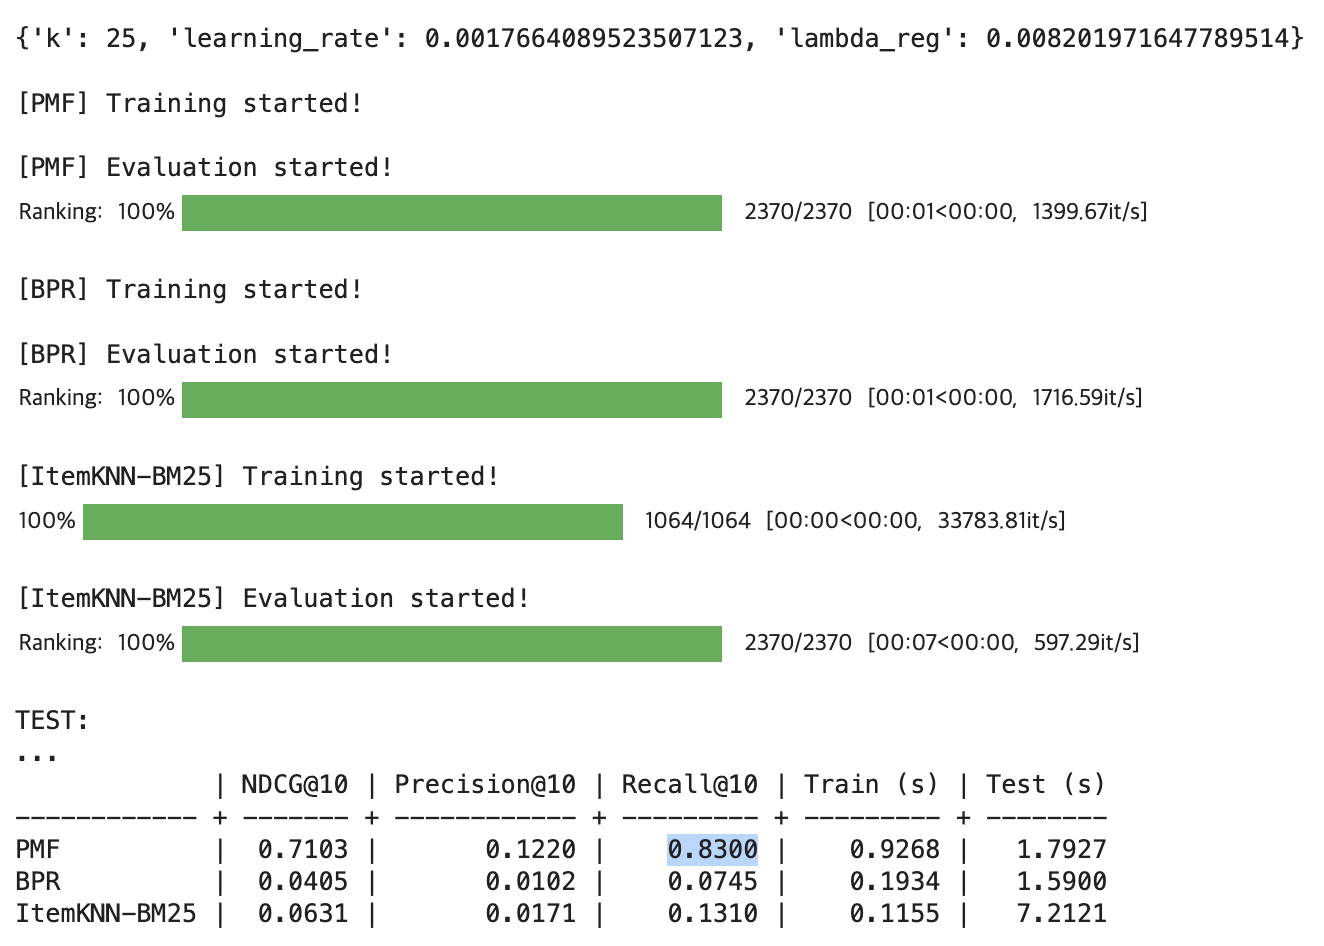

## Finally Save Model - PMF


In [39]:
import cornac

# Item Feature Modality 설정
item_feature_modality = cornac.data.FeatureModality(data=item_feature_dict)

# Split data based on ratio
rs = cornac.eval_methods.RatioSplit(
    data=dataset, test_size=0.2, rating_threshold=4.0, seed=123, item_feature=item_feature_modality, verbose=True
)

pmf = cornac.models.PMF(
    k=25, max_iter=100, learning_rate=0.001766, lambda_reg=0.0082019, seed=123
)
most_pop = cornac.models.MostPop()

# Define metrics used to evaluate the models
mae = cornac.metrics.MAE()
rmse = cornac.metrics.RMSE()
prec = cornac.metrics.Precision(k=10)
recall = cornac.metrics.Recall(k=10)
ndcg = cornac.metrics.NDCG(k=10)
auc = cornac.metrics.AUC()
mAP = cornac.metrics.MAP()

# Put it together into an experiment and run
exp = cornac.Experiment(
    eval_method=rs,
    models=[pmf],
    metrics=[mae, rmse, prec, recall, ndcg, auc, mAP],
    user_based=True,
    save_dir="save_models"
)

exp.run()

rating_threshold = 4.0
exclude_unknowns = True
---
Training data:
Number of users = 3501
Number of items = 1064
Number of ratings = 10835
Max rating = 5.0
Min rating = 1.0
Global mean = 4.1
---
Test data:
Number of users = 3501
Number of items = 1064
Number of ratings = 4044
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 3501
Total items = 1064

[PMF] Training started!


/usr/local/lib/python3.10/dist-packages/cornac/data/dataset.py:339: UserWarning: 7190 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/usr/local/lib/python3.10/dist-packages/cornac/data/dataset.py:339: UserWarning: 399 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)



[PMF] Evaluation started!


Rating:   0%|          | 0/4044 [00:00<?, ?it/s]

Ranking:   0%|          | 0/2370 [00:00<?, ?it/s]


TEST:
...
    |    MAE |   RMSE |    AUC |    MAP | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
--- + ------ + ------ + ------ + ------ + ------- + ------------ + --------- + --------- + --------
PMF | 0.4232 | 0.4501 | 0.9756 | 0.6605 |  0.7146 |       0.1211 |    0.8306 |    0.9046 |   9.9112



## Make Inferences using Model PMF

In [35]:
dataset[:10]

[(0.0, 2210300003.0, 5.0),
 (1.0, 2210220007.0, 2.0),
 (2.0, 2209070004.0, 5.0),
 (3.0, 2208200006.0, 4.0),
 (4.0, 2208260005.0, 5.0),
 (5.0, 2211060002.0, 5.0),
 (6.0, 2210040001.0, 4.0),
 (7.0, 2210270003.0, 5.0),
 (8.0, 2210270002.0, 3.0),
 (9.0, 2211130002.0, 3.0)]

In [41]:
user_id = 1.0
item_id = 2211130002.0

train_set = pmf.train_set

# Cornac의 학습 데이터에서 user_id와 item_id의 인덱스 찾기
user_idx = train_set.uid_map[user_id]  # user_id를 user_idx로 변환
item_idx = train_set.iid_map[item_id]  # item_id를 item_idx로 변환

prediction = pmf.score(user_idx=user_idx, item_idx=item_idx)

In [42]:
print(prediction)

2.809684852792727


In [98]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_items(model, target_item_id, N):
    # 학습된 PMF 모델에서 아이템 임베딩을 추출
    item_embeddings = pmf.get_item_vectors()  # 아이템 임베딩 행렬

    # 학습된 데이터셋 (item_idx와 item_id 매핑을 위해)
    train_set = pmf.train_set

    # item_id를 item_idx로 변환
    if target_item_id in train_set.iid_map:
        target_item_idx = train_set.iid_map[target_item_id]
    else:
        raise ValueError(f"Item ID {target_item_id} not found in the training set.")

    # 대상 아이템의 임베딩 벡터
    target_item_embedding = item_embeddings[target_item_idx].reshape(1, -1)

    # 모든 아이템 간의 코사인 유사도 계산
    similarities = cosine_similarity(target_item_embedding, item_embeddings).flatten()

    # 유사도가 높은 상위 N개 아이템의 인덱스 (자기 자신 제외)
    similar_item_indices = np.argsort(similarities)[::-1][1:N+1]  # 자기 자신 제외하고 상위 N개

    # 상위 N개 아이템의 ID 반환
    similar_items = [train_set.item_ids[idx] for idx in similar_item_indices]

    return similar_items

def get_item_info(item_id):
    item_info = merged_df[merged_df['VISIT_AREA_ID'] == int(item)]
    return item_info['VISIT_AREA_NM'].values[0], item_info['VISIT_AREA_TYPE_CD'].values[0]

In [77]:
df.head()

,userID,itemID,rating,timestamp
0,0,2210300003,5.0,2022-10-30
1,1,2210220007,2.0,2022-10-22
2,2,2209070004,5.0,2022-09-07
3,3,2208200006,4.0,2022-08-20
4,4,2208260005,5.0,2022-08-26


In [78]:
merged_df.head()

,VISIT_AREA_ID,TRAVEL_ID,VISIT_ORDER,VISIT_AREA_NM,VISIT_START_YMD,VISIT_END_YMD,ROAD_NM_ADDR,LOTNO_ADDR,X_COORD,Y_COORD,...,POI_NM,RESIDENCE_TIME_MIN,VISIT_AREA_TYPE_CD,REVISIT_YN,VISIT_CHC_REASON_CD,LODGING_TYPE_CD,DGSTFN,REVISIT_INTENTION,RCMDTN_INTENTION,SGG_CD
0,2210300003,a_a008632,7,송도센트럴파크,2022-10-30,2022-10-30,NaN,인천 연수구 송도동 24-5,126.638630,37.39306396,...,스트롤링가든브릿지,120.0,1,N,1.0,NaN,4.0,5.0,4.0,NaN
1,2210220007,d_d004269,11,원앙폭포,2022-10-22,2022-10-22,제주특별자치도 서귀포시 돈내코로 137,제주특별자치도 서귀포시 상효동 1463,126.581330,33.30017689,...,NaN,30.0,1,N,9.0,NaN,3.0,2.0,3.0,NaN
2,2209070004,c_c000751,11,쏠비치진도 인피니티풀,2022-09-07,2022-09-07,전남 진도군 의신면 송군길 30-40,전남 진도군 의신면 초사리 1204,126.327957,34.40073398,...,NaN,480.0,6,N,5.0,NaN,5.0,5.0,5.0,NaN
3,2208200006,d_d000233,18,소노캄제주 수영장,2022-08-20,2022-08-20,일주동로6347-17,제주특별자치도 서귀포시 표선면,126.792098,33.3055558,...,NaN,120.0,6,N,7.0,NaN,4.0,4.0,4.0,50130.0
4,2208260005,d_d000480,18,정방폭포,2022-08-26,2022-08-26,NaN,제주특별자치도 서귀포시 동홍동 299-3,126.571605,33.24499661,...,정방폭포,30.0,1,Y,2.0,NaN,5.0,5.0,5.0,NaN


In [96]:
merged_df.columns

Index(['VISIT_AREA_ID', 'TRAVEL_ID', 'VISIT_ORDER', 'VISIT_AREA_NM',
       'VISIT_START_YMD', 'VISIT_END_YMD', 'ROAD_NM_ADDR', 'LOTNO_ADDR',
       'X_COORD', 'Y_COORD', 'ROAD_NM_CD', 'LOTNO_CD', 'POI_ID', 'POI_NM',
       'RESIDENCE_TIME_MIN', 'VISIT_AREA_TYPE_CD', 'REVISIT_YN',
       'VISIT_CHC_REASON_CD', 'LODGING_TYPE_CD', 'DGSTFN', 'REVISIT_INTENTION',
       'RCMDTN_INTENTION', 'SGG_CD'],
      dtype='object')

In [104]:
result = set()
target_item_id = 2210300003.0
target_name, target_type = get_item_info(target_item_id)
print(f"Target Item : {target_name}, {target_type}")

print("Recommended Items")
similar_items = find_similar_items(pmf, target_item_id, 10)

for item in similar_items:
    item_info = merged_df[merged_df['VISIT_AREA_ID'] == int(item)]
    print("--------------------")
    item_name, item_type = get_item_info(item)
    print(f"Name: {item_name}, Type: {item_type}")
    result.add(item_name)

Target Item : 천지연폭포, 1
Recommended Items
--------------------
Name: 한라수목원, Type: 1
--------------------
Name: 제주동문재래시장, Type: 4
--------------------
Name: 홈플러스 서귀포점, Type: 4
--------------------
Name: 서귀포매일올레시장, Type: 4
--------------------
Name: 이호테우해수욕장, Type: 1
--------------------
Name: 고성오일시장, Type: 4
--------------------
Name: 아쿠아플라넷 제주, Type: 6
--------------------
Name: 루나피크닉, Type: 1
--------------------
Name: 안덕산방도서관, Type: 3
--------------------
Name: 천지연폭포, Type: 1


In [105]:
result

{'고성오일시장',
 '루나피크닉',
 '서귀포매일올레시장',
 '아쿠아플라넷 제주',
 '안덕산방도서관',
 '이호테우해수욕장',
 '제주동문재래시장',
 '천지연폭포',
 '한라수목원',
 '홈플러스 서귀포점'}